Actor-critic cartesian rocket
---

In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [114]:
class cartesian_rocket:
    def __init__(self,
                 dry_mass = 10.,
                 wet_mass = 100.,
                 isp = 600.,
                 time_step = 0.5,
                 drag_coef = 0.,
                 max_fuel_rate = .5, # per second
#                  throttle_rate = 0.1 #increase of fuel use 
                 reference_height = 200, #m, for barometric pressure
                 g = 9.81
                ):
        self.dry_mass = dry_mass
        self.wet_mass = wet_mass
        self.isp = isp
        self.time_step = time_step
        self.drag_coef = drag_coef
        self.max_fuel_rate = max_fuel_rate
#         self.throttle_rate = throttle_rate
        
        #keep track of time
        self.stopwatch = 0.
        
        #keep track of velocity
        self.velocity = np.array([0.,0.])
        
        #keep track of position
        self.position = np.array([0.,0.])
        
        #drag
        self.area = 1.
        self.reference_height = reference_height
        
        #gravity
        self.g = np.array([0., -g])
        
        #history.
        self.history_position = [
            self.position
        ]
        self.history_velocity = [
            self.velocity
        ]
        
        right = np.array([1.,0.])
        up = np.array([0.,1.])
        self.directions = {
            1:right,
            2:up,
            3:-right,
            4:-up
        }
    
    #increase fuel in direction. Adds to velocity at the cost of fuel
    def fire(self, direction_code):
        direction = self.directions[direction_code]
        fuel_used = self.max_fuel_rate * self.time_step
        if fuel_used > self.wet_mass:
            fuel_used = self.wet_mass
        self.wet_mass = self.wet_mass - fuel_used
        force = direction*self.time_step*self.isp*np.linalg.norm(self.g)*fuel_used
        accel = force / (self.wet_mass + self.dry_mass)
        self.velocity = self.velocity + accel
        return accel
        
    def apply_drag(self):
        atm = np.exp(-self.position[1]/self.reference_height)
        drag_force = -0.5*atm*self.drag_coef*self.area*np.linalg.norm(self.velocity)*self.velocity
        drag_dv =  self.time_step*drag_force / (self.wet_mass + self.dry_mass)
        drag_dv_norm = np.linalg.norm(drag_dv)
        velocity_norm = np.linalg.norm(self.velocity)
        if drag_dv_norm > 0.25*velocity_norm:
            print(f'Warning: drag dv is {100*drag_dv_norm/velocity_norm}% of velocity.')
        self.velocity = self.velocity + drag_dv
    
    def apply_gravity(self):
        self.velocity = self.velocity + self.time_step*self.g
        return self.velocity
    
    def advance(self, report = True):
#         self.apply_gravity()
#         self.apply_drag()
        self.position = self.position + self.velocity * self.time_step 
        self.history_position.append(self.position)
        self.history_velocity.append(self.velocity)
        self.stopwatch += self.time_step
        if report:
            state = np.array([self.position, self.velocity, [self.dry_mass, self.wet_mass]])
            state = np.reshape(state, (1,6,))                
            return state
        
    def is_crashed(self, ground_level):
        if self.position[1] < ground_level:
            return True
        else:
            return False
    
    def plot_trajectory(self, label = None, to_show = True, figsize = (12,12), gray_color = 1):
        color = str(gray_color)
        x = np.array(self.history_position)[:,0]
        y = np.array(self.history_position)[:,1]
        if to_show:
            plt.figure(figsize = figsize)
            plt.plot(x,y, label = label, color = color)
            plt.show()
        else:
            plt.plot(x,y, label = label, color = color)

In [115]:
#inputs are the state of the rocket. Six values returned from advance()
num_inputs = 6
#actions are fire right, up, left, down, none
num_actions = 5
num_hidden = 128


init_seed = 202212
initializer = tf.initializers.he_normal(init_seed)

inputs = keras.layers.Input(shape = (num_inputs,))
common1 = keras.layers.Dense(num_hidden, activation = 'relu', kernel_initializer=initializer)(inputs)
actor = keras.layers.Dense(num_actions, activation = 'softmax', kernel_initializer=initializer)(common1)
critic = keras.layers.Dense(1, kernel_initializer=initializer)(common1)
# common2 = keras.layers.Dense(num_hidden, activation = 'relu')(common1)
# actor = keras.layers.Dense(num_actions, activation = 'softmax')(common2)
# critic = keras.layers.Dense(1)(common2)
#
model = keras.Model(inputs = inputs, outputs = [actor, critic])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 128)          896         ['input_7[0][0]']                
                                                                                                  
 dense_19 (Dense)               (None, 5)            645         ['dense_18[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 1)            129         ['dense_18[0][0]']               
                                                                                            

In [116]:
target_vel = np.array([25., 0.])
target_alt = 60.

#gives error values for the velocity and altitude
def calculate_errors(rocket_state, target_velocity = target_vel, target_altitude = target_alt):
    pos_x, altitude, vel_x, vel_y, dry_mass, wet_mass = rocket_state[0]
#     velocity = np.array([vel_x, vel_y])
#     speed_square_error =  np.linalg.norm(velocity - target_velocity)**2
    speed_square_error =  (vel_x - target_velocity[0])**2 + (vel_y - target_velocity[1])**2
    altitude_square_error = (altitude - target_altitude)**2
    return speed_square_error, altitude_square_error
    

In [117]:
seed = 20222
rng = np.random.default_rng(seed)

gamma = 0.99
max_simulation_time = 20 #seconds
eps = np.finfo(np.float32).eps.item()


huber = tf.losses.Huber()

average loss: 15.185/sec at episode 1, rocket lasted 20.50 sec
average loss: 63.812/sec at episode 2, rocket lasted 20.50 sec
average loss: 11.904/sec at episode 3, rocket lasted 20.50 sec
average loss: -34.356/sec at episode 4, rocket lasted 20.50 sec
average loss: 21.117/sec at episode 5, rocket lasted 20.50 sec
average loss: 8.391/sec at episode 6, rocket lasted 20.50 sec
average loss: 3.135/sec at episode 7, rocket lasted 20.50 sec
average loss: -0.641/sec at episode 8, rocket lasted 20.50 sec
average loss: 23.018/sec at episode 9, rocket lasted 20.50 sec
average loss: 6.179/sec at episode 10, rocket lasted 20.50 sec


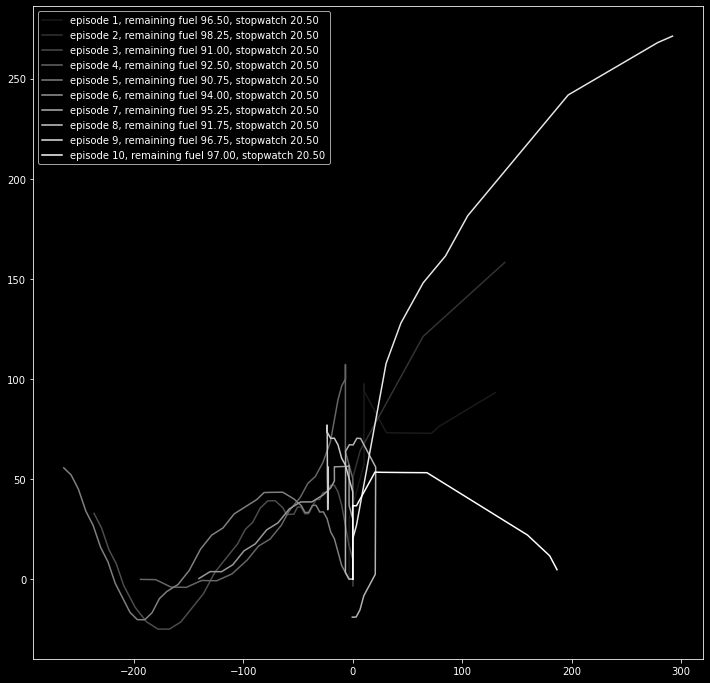

In [127]:
############################
#losses and rewards
############################


action_probs_history = []
critic_value_history = []
rewards_history = []




############################
#optimizer and learning rate
############################


# # is_learning_rate_decaying = False
# # # is_learning_rate_decaying = True
learning_rate_start = 0.00001
# # learning_rate_end = 0.0001

# if is_learning_rate_decaying:
#     learning_rate_decay = (learning_rate_end/learning_rate_start)**(1/num_episodes)
# else:
#     learning_rate_decay = 1



optimizer = tf.optimizers.Adam(learning_rate = learning_rate_start,
                              beta_1=0.9,
                              beta_2=0.999)

# optimizer = tf.optimizers.Adam(learning_rate = learning_rate_start, beta_1 = learning_rate_decay)

############################
# number of episodes
############################

num_episodes = 10
episode_update_period = 1
episode_count = 0


############################
# train!
############################
plt.figure(figsize = (12,12))

for epoch in range(num_episodes):

    action_probs_history.clear()
    critic_value_history.clear()
    rewards_history.clear()
    
    #make a new rocket on the launchpad
    rkt = cartesian_rocket()
    
    #optionally give it a little boost
#     rkt.velocity = rng.random(2)

    #prepare state for model
    starting_state = np.array([rkt.position, rkt.velocity, [rkt.dry_mass, rkt.wet_mass]])
    starting_state = np.reshape(starting_state, (1,6))
    state = tf.convert_to_tensor(starting_state)
    
    episode_reward = 0
    
    #################
    #run a simulation
    #################
    with tf.GradientTape() as tape:
        #until it hits ground level or goes over time, ...
#         while not rkt.is_crashed(ground_level = -25.) and rkt.stopwatch <= max_simulation_time:
        while rkt.stopwatch <= max_simulation_time: 
            #model gives a series of action probabilities and a critic value based on state
            action_probs, critic_value = model(state)
            
            #track critic value throughout simulation
            critic_value_history.append(critic_value[0,0])
            
            #use action probabilities to decide on an action and keep track of its log value
            # (bigger/more negative is less confident)
            
            
#             new_action_probs = np.squeeze(action_probs)
            new_action_probs = action_probs + 0.1
            action_probs = new_action_probs / sum(new_action_probs[0])
#             action = rng.choice(num_actions, p = action_probs)
            
            action = rng.choice(num_actions, p = np.squeeze(action_probs))
            
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            #fire in the appropriate direction. Changes rocket velocity at the cost of fuel
            # 0,1,2,3,4 are coast, fire right, fire up, fire left, fire down
            if action in [0]:
                pass
            else:
                rkt.fire(action)

            #advance time one step. Applies gravity and drag to velocity, then alters the rocket position.
            #returns the new rocket state in preparation for the next time step.
            state = rkt.advance()
            state = tf.convert_to_tensor(state)
            
            #calculate square errors -- distance to target altitude and velocity
            velocity_error, altitude_error = calculate_errors(state)
            total_error = velocity_error+altitude_error#-rkt.stopwatch
            total_reward = -total_error #100000.-total_error
            rewards_history.append(total_reward)
            episode_reward += total_reward        
    
        # push good rewards (with a discount) back over the simulation ---
        # this gives actions that lead to an improved reward 
        rewards = []
        discounted_sum = 0
    
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma*discounted_sum
            rewards.insert(0, discounted_sum)
        rewards = np.array(rewards)
        
        #normalize rewards.
        rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + eps)
        rewards = rewards.tolist()
        
        history = zip(action_probs_history, critic_value_history, rewards)
        actor_losses = []
        critic_losses = []
        for log_prob, critic_reward, true_reward in history:
            diff = true_reward - critic_reward
#             actor_losses.append(-log_prob*abs_diff)
            critic_loss = huber(tf.expand_dims(critic_reward, 0), tf.expand_dims(true_reward,0))
            critic_losses.append(
                critic_loss
            )
            actor_loss = -log_prob*diff
            actor_losses.append(actor_loss)
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
               
        
    episode_count += 1
    if episode_count % episode_update_period == 0:
        template = 'average loss: {:.3f}/sec at episode {}, rocket lasted {:.2f} sec'
        print(template.format(loss_value/rkt.stopwatch, episode_count, rkt.stopwatch))
#         model.save(f'./actor_critic_rocket_models/model_{episode_count}.tf')
        rkt.plot_trajectory(label='episode {}, remaining fuel {:.2f}, stopwatch {:.2f}'.format(episode_count,rkt.wet_mass,rkt.stopwatch), to_show=False, gray_color = episode_count/num_episodes)

#         print(action_probs_history)

#     if is_learning_rate_decaying:
#         optimizer.learning_rate = optimizer.learning_rate*learning_rate_decay
# plt.xlim(-10, 1000)
# plt.ylim(-10, 100)
plt.legend();

In [125]:
grads

[<tf.Tensor: shape=(6, 128), dtype=float32, numpy=
 array([[ 0.00000000e+00,  0.00000000e+00, -5.80322205e+02,
          0.00000000e+00,  9.54141907e+02, -8.95079117e+01,
          1.19961743e+03, -5.09541809e+02,  0.00000000e+00,
         -1.24577749e+00, -8.65850586e+02,  0.00000000e+00,
          2.08551834e+02,  0.00000000e+00, -7.49341297e+00,
          0.00000000e+00,  0.00000000e+00, -3.00671883e+01,
          0.00000000e+00, -4.37380981e+01,  2.27384281e+01,
          3.51061325e+01,  0.00000000e+00, -1.21726782e+03,
          0.00000000e+00,  0.00000000e+00, -5.04203247e+02,
         -1.10218143e+00,  0.00000000e+00, -1.75688982e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          2.71342725e+03,  0.00000000e+00,  0.00000000e+00,
         -6.65346289e+00, -2.93012834e+00,  0.00000000e+00,
          5.99060913e+02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -4.95928864e+02,  5.41471008e+02,
         -4.24286423e+01, -1.22910681e+03,  1.597